# Regression Modelling - Time Series

### Features considered:

All features are considered by Year:

Raw Sentiment-related Features: 

- 1. Total Reviews
- 2. Total Positive Reviews
- 3. Total Negative Reviews
- 4. Total Neutral Reviews

4Wheeler-related Features:

- 5. Number of cars produced
- 6. Number of cars sold 
- 7. Number of cars exported

Economic-related Features:

- 8. Steel Price
- 9. Rupee Value

Target Variable : 

- 10. Growth% in domestic Auto component Turnover year on year

#### Sentiment Reviews scraped for the following products from Amazon India:

1. Car Tyre
2. Car Wheels
3. Car Windshields
4. Car Foglamp
5. Car SeatCover
6. Car Wiper
7. Car Engine Oil

We have Derived the following Features for Sentiment Analysis:

1. Share of Positive Reviews each year
2. Share of Negative Reviews each year
3. Share of Neutral Reviews each year

Around 2,359 Reviews scrapped for Analysis

#### Modelling Procedure

1. Separate Time-Series data into Train and Test
2. Feature Selection based on Correlation Matrix and VIF 
3. Input AutoSales Growth with selected features in the Model
4. Output will be determining Auto Sales Growth% in the next Year
5. Error of the model will be incorporated in our predictions

#####  Train Data Split - 2019, 2020, 2021

##### Test Data - 2022

In [680]:
#!pip install vaderSentiment
#!pip install wordcloud
#!pip install -U gensim
#!pip install xgboost
#!pip install plotly
#!pip install textblob
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#!pip install seaborn
import time
t0 = time.time()
import pandas as pd
import numpy as np
import re
import string
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#from wordcloud import WordCloud
from pprint import pprint

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import ensemble
import xgboost, string 
import csv,nltk
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from nltk.corpus import webtext
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from gensim.parsing.preprocessing import strip_punctuation, strip_tags, strip_numeric
from nltk.stem.wordnet import WordNetLemmatizer   
from nltk.corpus import stopwords
import string
import seaborn as sns
import calendar

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics

t1 = time.time()
print("Time taken to load/import libraries ", round(t1-t0,3))

Time taken to load/import libraries  0.001


We are trying to predict the growth in the sales of Auto Component Industry by trying to understand the impact of different attributes like Sentiments, 4 Wheeler production, Raw material pricing on Auto components growth year on year.

In [681]:
#Select datasets
cartyre_df = pd.read_csv("amazon_cartyre.csv")
carengineoil_df = pd.read_csv("amazon_carengineoil.csv")
carfoglamp_df = pd.read_csv("amazon_carfoglamp.csv")
carwheel_df = pd.read_csv("amazon_carwheel.csv")
carwindshwash_df = pd.read_csv("amazon_carwindshwash.csv")
carwiper_df = pd.read_csv("amazon_carwiper.csv")
carseatcover_df = pd.read_csv("amazon_carseatcover.csv")

In [682]:
#Merge Datasets
Review_df = pd.concat([cartyre_df,carengineoil_df,carfoglamp_df,carwheel_df,carwindshwash_df,carwiper_df,carseatcover_df])
Review_df

,product_name,product_link,review_date,review_title,review_rating,review_comment
0,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,15 September 2020,good tyres,5,so far so goodwarranty of 5yearshopefully they...
1,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,30 June 2022,the best tyre that you can get at the entry le...,5,i used the same model tyre jk taximax for my c...
2,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,26 November 2020,tyree are good,5,as on now it is ok
3,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,7 October 2021,i got a back date tyre from cloudtail,3,i didnt liked the packaging as it was cheaper ...
4,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,23 March 2022,go for it 165 80 r14 dzire tour,5,good build quality jk known for grip and milag...
...,...,...,...,...,...,...
199,Abhsant Leather Memory Foam Car Seat Headrest ...,https://www.amazon.in/Abhsant-Headrest-Pillow-...,18 December 2021,not for xuv and merc,3,the headrest is great but it s doesn t fit xuv...
200,Abhsant Leather Memory Foam Car Seat Headrest ...,https://www.amazon.in/Abhsant-Headrest-Pillow-...,10 September 2020,good product check sizes and dimensions,4,well first of all i returned the product becau...
201,Abhsant Leather Memory Foam Car Seat Headrest ...,https://www.amazon.in/Abhsant-Headrest-Pillow-...,8 March 2022,worth the money,5,all good thanks
202,Abhsant Leather Memory Foam Car Seat Headrest ...,https://www.amazon.in/Abhsant-Headrest-Pillow-...,14 November 2021,very nice,5,amazing product does the job very well


In [683]:
stopwords = nltk.corpus.stopwords.words("english")

In [684]:
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if(not token in stopwords):            
            if re.search('[a-zA-Z]',token):
                filtered_tokens.append(token)
    return filtered_tokens

In [685]:
totalvocab_tokenized =[]
for i in Review_df['review_comment']:    
    allword_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allword_tokenized) 
print("Get 10 words from list ",totalvocab_tokenized[:10])
print("Total number of tokenized list ", len(totalvocab_tokenized))

Get 10 words from list  ['far', 'goodwarranty', '5yearshopefully', 'come', 'yearsearlier', 'tyres', 'jk', 'sothey', 'good', 'used']
Total number of tokenized list  37139


In [686]:
stemmer = SnowballStemmer("english")

In [687]:
def tokenize_and_stem(text):    
    filtered_tokens = tokenize_only(text)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [688]:
totalvocab_stemmed = []
for i in Review_df['review_comment']:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
totalvocab_stemmed
print("After stemming : ")
print("Get 10 words from list ",totalvocab_stemmed[:10])
print("Total number of tokenized list ", len(totalvocab_stemmed))

After stemming : 
Get 10 words from list  ['far', 'goodwarranti', '5yearshop', 'come', 'yearsearli', 'tyre', 'jk', 'sothey', 'good', 'use']
Total number of tokenized list  37139


In [689]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rohini\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [690]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(tokenize_only(text))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))           
    return newlist

Review_df['POS tagged'] = Review_df['review_comment'].apply(token_stop_pos)
Review_df.head()

,product_name,product_link,review_date,review_title,review_rating,review_comment,POS tagged
0,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,15 September 2020,good tyres,5,so far so goodwarranty of 5yearshopefully they...,"[(far, r), (goodwarranty, r), (5yearshopefully..."
1,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,30 June 2022,the best tyre that you can get at the entry le...,5,i used the same model tyre jk taximax for my c...,"[(used, v), (model, n), (tyre, n), (jk, n), (t..."
2,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,26 November 2020,tyree are good,5,as on now it is ok,"[(ok, n)]"
3,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,7 October 2021,i got a back date tyre from cloudtail,3,i didnt liked the packaging as it was cheaper ...,"[(didnt, n), (liked, v), (packaging, v), (chea..."
4,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,23 March 2022,go for it 165 80 r14 dzire tour,5,good build quality jk known for grip and milag...,"[(good, a), (build, n), (quality, n), (jk, n),..."


In [691]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

Review_df['Lemma'] = Review_df['POS tagged'].apply(lemmatize)
Review_df.head()

,product_name,product_link,review_date,review_title,review_rating,review_comment,POS tagged,Lemma
0,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,15 September 2020,good tyres,5,so far so goodwarranty of 5yearshopefully they...,"[(far, r), (goodwarranty, r), (5yearshopefully...",far goodwarranty 5yearshopefully come yearse...
1,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,30 June 2022,the best tyre that you can get at the entry le...,5,i used the same model tyre jk taximax for my c...,"[(used, v), (model, n), (tyre, n), (jk, n), (t...",use model tyre jk taximax car previously wel...
2,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,26 November 2020,tyree are good,5,as on now it is ok,"[(ok, n)]",ok
3,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,7 October 2021,i got a back date tyre from cloudtail,3,i didnt liked the packaging as it was cheaper ...,"[(didnt, n), (liked, v), (packaging, v), (chea...",didnt like package cheap n stsickers present...
4,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,23 March 2022,go for it 165 80 r14 dzire tour,5,good build quality jk known for grip and milag...,"[(good, a), (build, n), (quality, n), (jk, n),...",good build quality jk know grip milage also ...


In [692]:
analyzer = SentimentIntensityAnalyzer()
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
Review_df['Vader Sentiment'] = Review_df['Lemma'].apply(vadersentimentanalysis)

In [693]:
def vader_analysis(compound):
    if compound > 0:
        return 'Positive'
    elif compound == 0:
        return 'Neutral'
    else:
        return 'Negative'
Review_df['Vader Analysis'] = Review_df['Vader Sentiment'].apply(vader_analysis)
Review_df.head()

,product_name,product_link,review_date,review_title,review_rating,review_comment,POS tagged,Lemma,Vader Sentiment,Vader Analysis
0,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,15 September 2020,good tyres,5,so far so goodwarranty of 5yearshopefully they...,"[(far, r), (goodwarranty, r), (5yearshopefully...",far goodwarranty 5yearshopefully come yearse...,0.5859,Positive
1,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,30 June 2022,the best tyre that you can get at the entry le...,5,i used the same model tyre jk taximax for my c...,"[(used, v), (model, n), (tyre, n), (jk, n), (t...",use model tyre jk taximax car previously wel...,0.9678,Positive
2,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,26 November 2020,tyree are good,5,as on now it is ok,"[(ok, n)]",ok,0.2960,Positive
3,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,7 October 2021,i got a back date tyre from cloudtail,3,i didnt liked the packaging as it was cheaper ...,"[(didnt, n), (liked, v), (packaging, v), (chea...",didnt like package cheap n stsickers present...,-0.3204,Negative
4,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,23 March 2022,go for it 165 80 r14 dzire tour,5,good build quality jk known for grip and milag...,"[(good, a), (build, n), (quality, n), (jk, n),...",good build quality jk know grip milage also ...,0.8225,Positive


In [694]:
sentiment_analysis = Review_df.groupby(['Vader Analysis']).size().reset_index(name='counts')
sentiment_analysis

,Vader Analysis,counts
0,Negative,347
1,Neutral,263
2,Positive,1749


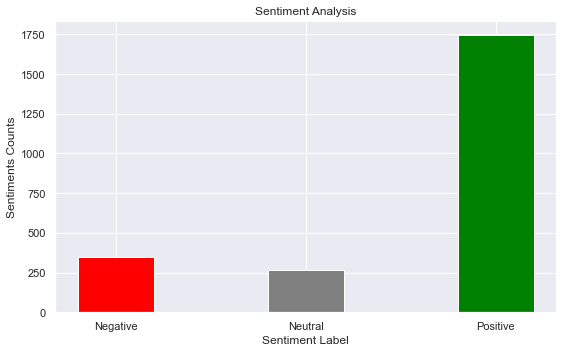

In [695]:
fig = plt.figure(figsize = (8, 5)) 
# creating the bar plot
plt.bar(sentiment_analysis['Vader Analysis'], sentiment_analysis['counts'], color=['red','gray','green'], width = 0.4) 
plt.xlabel("Sentiment Label")
plt.ylabel("Sentiments Counts")
plt.title("Sentiment Analysis")
plt.show()

In [696]:
Review_df['Year'] = Review_df['review_date'].str[-4:]
Review_df

,product_name,product_link,review_date,review_title,review_rating,review_comment,POS tagged,Lemma,Vader Sentiment,Vader Analysis,Year
0,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,15 September 2020,good tyres,5,so far so goodwarranty of 5yearshopefully they...,"[(far, r), (goodwarranty, r), (5yearshopefully...",far goodwarranty 5yearshopefully come yearse...,0.5859,Positive,2020
1,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,30 June 2022,the best tyre that you can get at the entry le...,5,i used the same model tyre jk taximax for my c...,"[(used, v), (model, n), (tyre, n), (jk, n), (t...",use model tyre jk taximax car previously wel...,0.9678,Positive,2022
2,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,26 November 2020,tyree are good,5,as on now it is ok,"[(ok, n)]",ok,0.2960,Positive,2020
3,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,7 October 2021,i got a back date tyre from cloudtail,3,i didnt liked the packaging as it was cheaper ...,"[(didnt, n), (liked, v), (packaging, v), (chea...",didnt like package cheap n stsickers present...,-0.3204,Negative,2021
4,JK Tyre 165/80 R14 Taximax Tubeless Car Tyre,https://www.amazon.in/Tyres-Taxi-Max-Tubeless-...,23 March 2022,go for it 165 80 r14 dzire tour,5,good build quality jk known for grip and milag...,"[(good, a), (build, n), (quality, n), (jk, n),...",good build quality jk know grip milage also ...,0.8225,Positive,2022
...,...,...,...,...,...,...,...,...,...,...,...
199,Abhsant Leather Memory Foam Car Seat Headrest ...,https://www.amazon.in/Abhsant-Headrest-Pillow-...,18 December 2021,not for xuv and merc,3,the headrest is great but it s doesn t fit xuv...,"[(headrest, a), (great, a), (fit, a), (xuv, n)...",headrest great fit xuv middle row seat space...,0.9531,Positive,2021
200,Abhsant Leather Memory Foam Car Seat Headrest ...,https://www.amazon.in/Abhsant-Headrest-Pillow-...,10 September 2020,good product check sizes and dimensions,4,well first of all i returned the product becau...,"[(well, r), (first, r), (returned, v), (produc...",well first return product fit middle seat ro...,0.9621,Positive,2020
201,Abhsant Leather Memory Foam Car Seat Headrest ...,https://www.amazon.in/Abhsant-Headrest-Pillow-...,8 March 2022,worth the money,5,all good thanks,"[(good, a), (thanks, n)]",good thanks,0.7003,Positive,2022
202,Abhsant Leather Memory Foam Car Seat Headrest ...,https://www.amazon.in/Abhsant-Headrest-Pillow-...,14 November 2021,very nice,5,amazing product does the job very well,"[(amazing, v), (product, n), (job, n), (well, r)]",amaze product job well,0.6808,Positive,2021


In [697]:
senti_reg = Review_df.groupby(['Year', 'Vader Analysis']).size().reset_index(name='counts').sort_values(['Year'])
senti_reg

,Year,Vader Analysis,counts
0,2019,Negative,26
1,2019,Neutral,25
2,2019,Positive,194
3,2020,Negative,52
4,2020,Neutral,35
5,2020,Positive,326
6,2021,Negative,128
7,2021,Neutral,99
8,2021,Positive,633
9,2022,Negative,141


<AxesSubplot:xlabel='Year'>

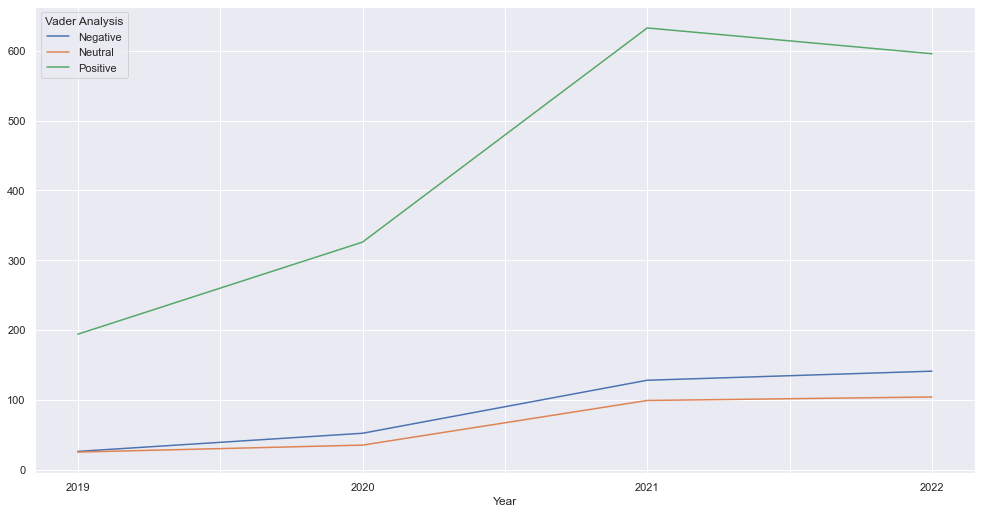

In [698]:
import matplotlib.pyplot as plt

senti_reg = senti_reg.pivot(index='Year', columns='Vader Analysis', values='counts')

senti_reg.plot()

In [699]:
#2019
total_reviews_2019 = Review_df.loc[(Review_df['Year']=='2019'), 'Vader Analysis'].count()
positive_review_2019 = Review_df.loc[(Review_df['Vader Analysis']=='Positive') & (Review_df['Year']=='2019'),'Vader Analysis'].count()
negative_review_2019 = Review_df.loc[(Review_df['Vader Analysis']=='Negative') & (Review_df['Year']=='2019'),'Vader Analysis'].count()
neutral_review_2019 = Review_df.loc[(Review_df['Vader Analysis']=='Neutral') & (Review_df['Year']=='2019'),'Vader Analysis'].count()

#2020
total_reviews_2020 = Review_df.loc[(Review_df['Year']=='2020'), 'Vader Analysis'].count()
positive_review_2020 = Review_df.loc[(Review_df['Vader Analysis']=='Positive') & (Review_df['Year']=='2020'),'Vader Analysis'].count()
negative_review_2020 = Review_df.loc[(Review_df['Vader Analysis']=='Negative') & (Review_df['Year']=='2020'),'Vader Analysis'].count()
neutral_review_2020 = Review_df.loc[(Review_df['Vader Analysis']=='Neutral') & (Review_df['Year']=='2020'),'Vader Analysis'].count()

#2021
total_reviews_2021 = Review_df.loc[(Review_df['Year']=='2021'), 'Vader Analysis'].count()
positive_review_2021 = Review_df.loc[(Review_df['Vader Analysis']=='Positive') & (Review_df['Year']=='2021'),'Vader Analysis'].count()
negative_review_2021 = Review_df.loc[(Review_df['Vader Analysis']=='Negative') & (Review_df['Year']=='2021'),'Vader Analysis'].count()
neutral_review_2021 = Review_df.loc[(Review_df['Vader Analysis']=='Neutral') & (Review_df['Year']=='2021'),'Vader Analysis'].count()

#2022
total_reviews_2022 = Review_df.loc[Review_df['Year']=='2022', 'Vader Analysis'].count()
positive_review_2022 = Review_df.loc[(Review_df['Vader Analysis']=='Positive') & (Review_df['Year']=='2022'),'Vader Analysis'].count()
negative_review_2022 = Review_df.loc[(Review_df['Vader Analysis']=='Negative') & (Review_df['Year']=='2022'),'Vader Analysis'].count()
neutral_review_2022 = Review_df.loc[(Review_df['Vader Analysis']=='Neutral') & (Review_df['Year']=='2022'),'Vader Analysis'].count()

In [782]:
auto_sales_2019 = 395902
auto_sales_2020 = 349637
auto_sales_2021 = 340733
auto_sales_2022 = 393254
Car_Production_2017 = 3047582
Car_Production_2018 = 3288581
Car_Production_2019 = 3377389
Car_Production_2020 = 2773519
Car_Production_2021 = 2711457
Car_Production_2022 = 3069499
Car_Sales_2017 = 3801670
Car_Sales_2018 = 4020267
Car_Sales_2019 = 4028471
Car_Sales_2020 = 3424564
Car_Sales_2021 = 3062280
Car_Sales_2022 = 3650698
Car_Growth_2019 = 0.02
Car_Growth_2020 = -0.15
Car_Growth_2021 = -0.11
Car_Growth_2022 = 0.19
Car_Export_2017 = 758727
Car_Export_2018 = 748366
Car_Export_2019 = 676192
Car_Export_2020 = 662118
Car_Export_2021 = 404397
Car_Export_2022 = 577875
auto_sales_gr_2019 = 0.145
auto_sales_gr_2020 = -0.117
auto_sales_gr_2021 = -0.03
auto_sales_gr_2022 = 0.1541
steel_price_2019 = 4135
steel_price_2020 = 3753
steel_price_2021 = 4401
steel_price_2022 = 4617 
rupee_value_2019 = 7056
rupee_value_2020 = 7597
rupee_value_2021 = 8019
rupee_value_2022 = 8411

In [414]:
total_reviews_2019

245

In [415]:
type(auto_sales_gr_2021)

float

In [783]:
dict_summary = {'Year':['2019','2020', '2021'],
               'Reviews Total':[total_reviews_2019,total_reviews_2020,total_reviews_2021],
               'Positive Reviews': [positive_review_2019,positive_review_2020,positive_review_2021],
               'Negative Reviews': [negative_review_2019,negative_review_2020,negative_review_2021],
               'Neutral Reviews': [neutral_review_2019, neutral_review_2020, neutral_review_2021], 
               'Production Car': [Car_Production_2019,Car_Production_2020,Car_Production_2021],
               'Sales Car': [Car_Sales_2019,Car_Sales_2020,Car_Sales_2021],
               'Export Car': [Car_Export_2019,Car_Export_2020,Car_Export_2021],
               'Sales INR': [auto_sales_2019,auto_sales_2020,auto_sales_2021],
                'Sales Growth' : [auto_sales_gr_2019,auto_sales_gr_2020,auto_sales_gr_2021],
               'Steel Price': [steel_price_2019, steel_price_2020, steel_price_2021],
               'Rupee Value' : [rupee_value_2019, rupee_value_2020, rupee_value_2021],
               'Car Growth' : [Car_Growth_2019, Car_Growth_2020, Car_Growth_2021]}

In [784]:
dict_summary_test = {'Year':[ '2022'],
               'Reviews Total':[ total_reviews_2022],
               'Positive Reviews': [ positive_review_2022],
               'Negative Reviews': [negative_review_2022],
               'Neutral Reviews': [neutral_review_2022], 
               'Production Car': [Car_Production_2022],
               'Sales Car': [Car_Sales_2022],
               'Export Car': [Car_Export_2022],
               'Sales INR': [ auto_sales_2022],
                    'Sales Growth' : [auto_sales_gr_2022],
                'Steel Price': [steel_price_2022],
                'Rupee Value': [rupee_value_2022],
                    'Car Growth' : [Car_Growth_2022]}

##### Train Summary Dataframe

In [785]:
df_summary = pd.DataFrame(dict_summary)

In [786]:
df_summary['Positive share'] = df_summary['Positive Reviews']/df_summary['Reviews Total']
df_summary['Negative share'] = df_summary['Negative Reviews']/df_summary['Reviews Total']
df_summary['Neutral share'] = df_summary['Neutral Reviews']/df_summary['Reviews Total']
df_summary

,Year,Reviews Total,Positive Reviews,Negative Reviews,Neutral Reviews,Production Car,Sales Car,Export Car,Sales INR,Sales Growth,Steel Price,Rupee Value,Car Growth,Positive share,Negative share,Neutral share
0,2019,245,194,26,25,3377389,4028471,676192,395902,0.145,4135,7056,0.02,0.791837,0.106122,0.102041
1,2020,413,326,52,35,2773519,3424564,662118,349637,-0.117,3753,7597,-0.15,0.789346,0.125908,0.084746
2,2021,860,633,128,99,2711457,3062280,404397,340733,-0.030,4401,8019,-0.11,0.736047,0.148837,0.115116


#####  Test Summary Dataframe

In [787]:
df_summary_test = pd.DataFrame(dict_summary_test)

In [788]:
df_summary_test['Positive share'] = df_summary_test['Positive Reviews']/df_summary_test['Reviews Total']
df_summary_test['Negative share'] = df_summary_test['Negative Reviews']/df_summary_test['Reviews Total']
df_summary_test['Neutral share'] = df_summary_test['Neutral Reviews']/df_summary_test['Reviews Total']
df_summary_test

,Year,Reviews Total,Positive Reviews,Negative Reviews,Neutral Reviews,Production Car,Sales Car,Export Car,Sales INR,Sales Growth,Steel Price,Rupee Value,Car Growth,Positive share,Negative share,Neutral share
0,2022,841,596,141,104,3069499,3650698,577875,393254,0.1541,4617,8411,0.19,0.70868,0.167658,0.123662


#### Correlation HeatMap

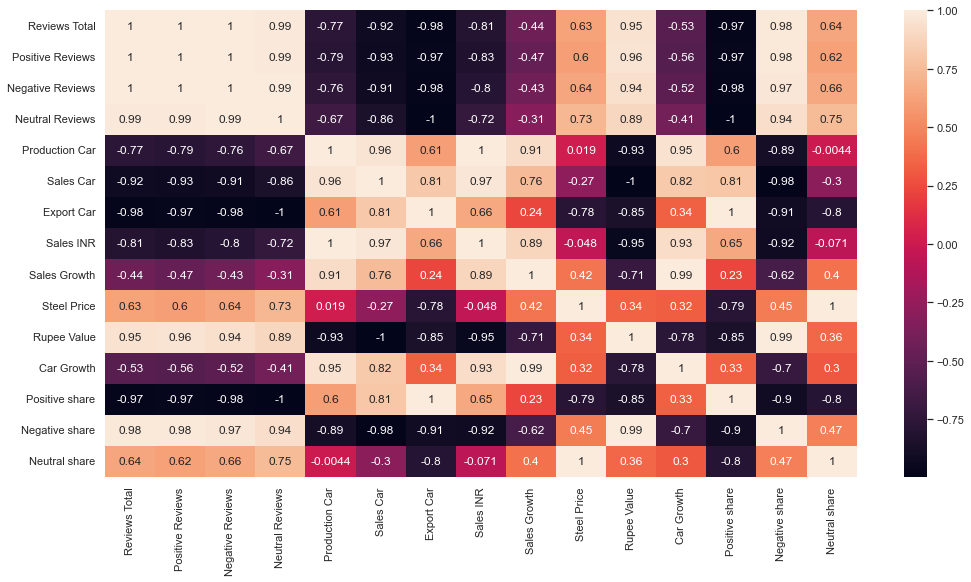

In [789]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_summary.corr(),annot=True)
plt.show()

##### Summary of HeatMap

- 1. There is a high negative correlation between AutoSales (Sales INR) and Negative Share (Share of Negative Reviews each year)
- 2. There is a high positive correlation between AutoSales (Sales INR) and Positive Review share

So for our model, we will fit the regression line with Negative share and Positive share of Reviews

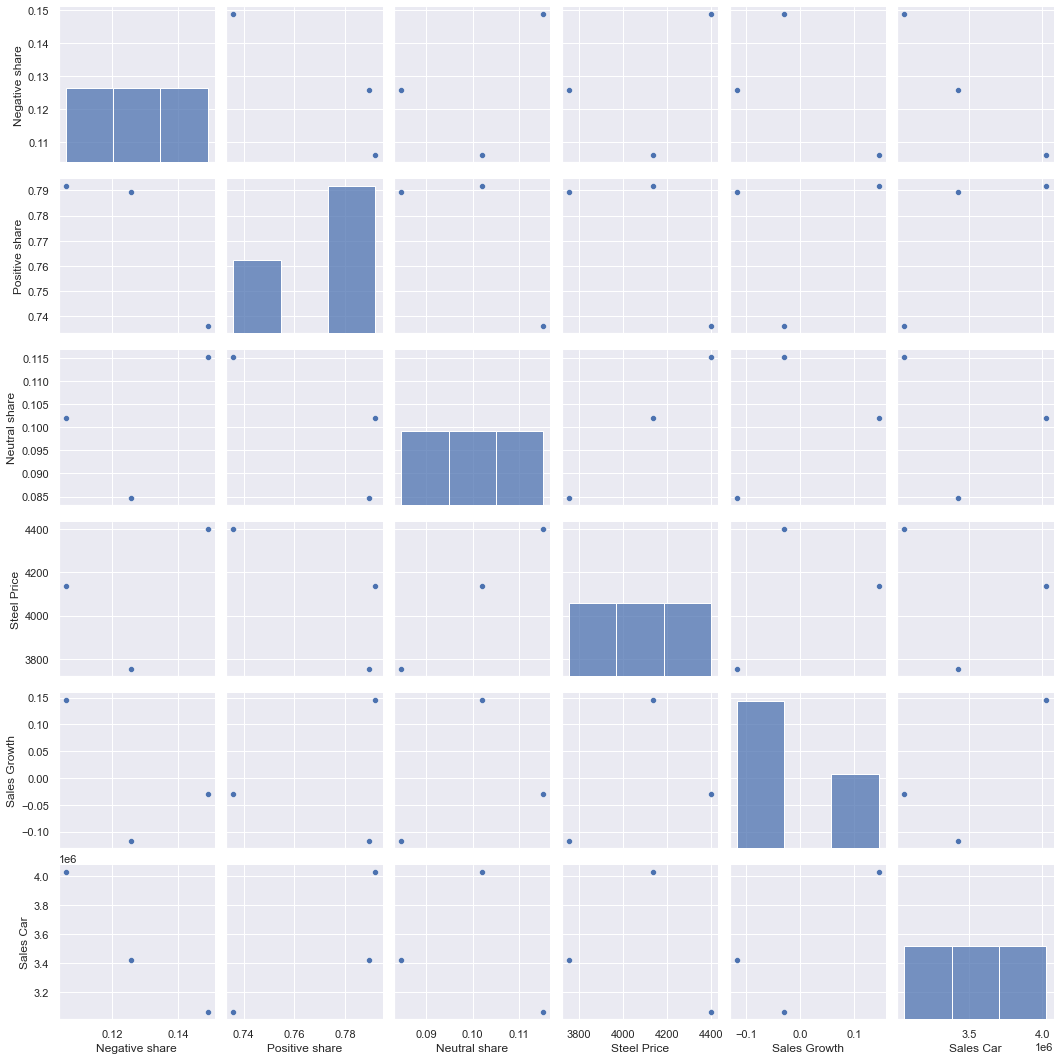

In [710]:
df = df_summary[['Negative share','Positive share','Neutral share', 'Steel Price', 'Sales Growth','Sales Car']]

sns.pairplot(df, kind="scatter")
plt.show()

In [800]:
from scipy.stats import linregress
linregress(df_summary['Car Growth'], df_summary['Sales Growth'])

LinregressResult(slope=1.4930379746835443, intercept=0.11877637130801687, rvalue=0.9944825110581318, pvalue=0.06690610432645502, stderr=0.157492383557422, intercept_stderr=0.017011121663497428)

##### Understading Multicollinearity of features based on VIF (Variance Inflation Factor)

In [790]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df_summary[[ 'Positive share','Sales Growth']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF Factor
0,Positive share,1.000002
1,Sales Growth,1.000002


Since VIF factor<4 so multicollinearity does not exist

In [802]:
import statsmodels.api as sm
mod = sm.OLS(exog=df_summary[['Positive share', 'Car Growth']], endog=df_summary['Sales Growth'])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:           Sales Growth   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              25.52
Date:                Sat, 13 Aug 2022   Prob (F-statistic):                       0.139
Time:                        13:29:14   Log-Likelihood:                          8.3215
No. Observations:                   3   AIC:                                     -12.64
Df Residuals:                       1   BIC:                                     -14.45
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\Users\Rohini\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


OLS Regresssion Inference:

Independant Variables - Positive share, Negative Reviews
Dependant Variables - Sales Growth

Model Regression Assessment

- R-squared: the 0.981 or 98.1% R-squared denotes the variation in dependant variable which is explained by the independant variables. This is considerably good since we have sentiment and 4wheeler related variables explaining variation in Auto component sales 

- Adjusted R-squared: It increases when we add new variables. With other sets of features, our Adjusted R-square has increased compared to other sets of features

- F - statistic: F-test of overall significance indicates whether linear regression model provides a better fit to the data than a model that contains no independant values. Our model is predicting better.

- Prob (F-statistic) : this singifies the overall significance of the regression. It should be closer to zero. We have a value of 0.139 meaning our model is significant.

- AIC : this is the lowest AIC compared to other sets of features we have tried

- BIC : this is the lowest BIC compared to other sets of fetures we have tried building the model 

Variable Assessment

- P Value : The p value is used to signify whether the model achieves our standard of significance. Here, Car Growth has a p-value of 0.89% which is below the desired standard Significance level of 5%. Here positive share has a significance of 12% which is under the tolerable range of statistical significance.

Model Assumption Assessment

- Skew : if skewness factor is closer to zero, the residual distribution shows normalcy in it's distribution. Here, the skew of 0.386 indicating a positive skewness and moderate normalcy

- Kurtosis : here, the kurtosis factor or Peakness is just on the acceptable range which should be with below +1.5 or above -1.5, indicating fewer chances of having outliers in our model

- Durbin Watson : for homoskedasticity, the value should be between 1 to 2, which in our case is just over 2 so it is tolerable. Homoscedasticity, or homogeneity of variances, is an assumption of equal or similar variances in different groups being compared. This is an important assumption of parametric statistical tests because they are sensitive to any dissimilarities

- Cond Number: this denotes sensitivity of a function's output compared to it's input which should ideally be below 30.

### Model Interpretations

eval_env: 1


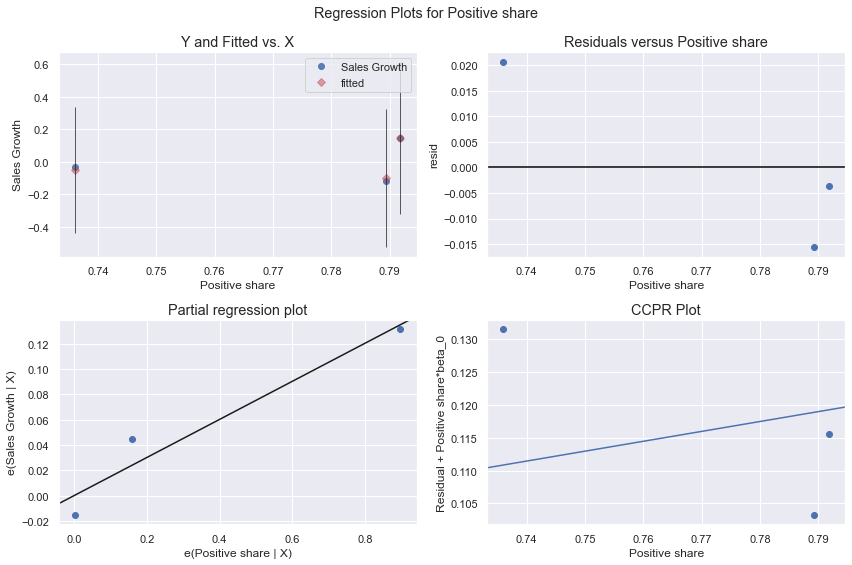

In [793]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(res, 'Positive share', fig=fig)

We can observe a positive linear relationship between share of positive reviews and auto component sales growth

eval_env: 1


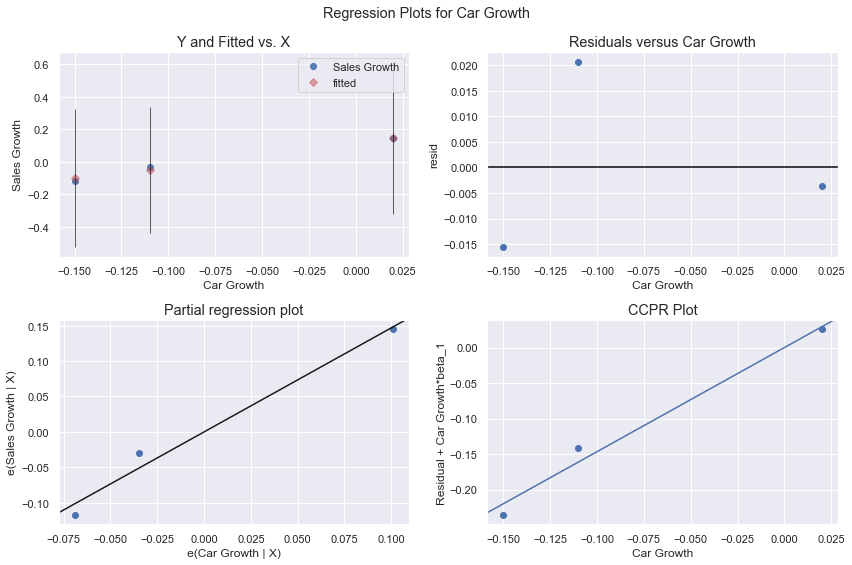

In [794]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(res, 'Car Growth', fig=fig)

We can observe a positive linear relationship between sales growth of 4wheelers and sales growth of autocomponent sales

### Model Evaluation 

In [795]:
X = df_summary_test[['Positive share','Car Growth']]
Y = df_summary_test['Sales Growth']
X.head(10)

,Positive share,Car Growth
0,0.70868,0.19


In [796]:
Y

0    0.1541
Name: Sales Growth, dtype: float64

In [797]:
pred_val = res.predict(X)
error_y = pred_val - Y

In [798]:
pred_val

0    0.385708
dtype: float64

In [799]:
error_y

0    0.231608
dtype: float64

We have predicted a growth in auto component sales by 38.57% in 2022 as opposed to an actual growth of 15.41% observed in 2022. (Since, our model comprises of Share of Positive Reviews which is slightly declining in the 2022 and Growth in 4Wheeler Sales which has seen a sudden increase of 19% in 2022 (mainly due to post pandemic recovery happening at a faster rate), coupled with fact that the correlation between car sales is 0.98 and positive reviews is 0.23, our predictions are higher than actual growth rate.)

There are multiple other factors like increase in commodities pricing, increase in rupee value, decrease in trade of auto components which will impact the overall growth in the sales of auto components

References:

